In [131]:
import pandas as pd
import numpy as np
import statistics 
import seaborn as sns
import pickle
import statsmodels.api as sm
from IPython.display import display
from sklearn import metrics, neighbors, preprocessing
from sklearn.metrics import auc, roc_curve, roc_auc_score, classification_report
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder as SklearnOneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

import matplotlib.pyplot as plt
plt.style.use('seaborn-ticks')
%matplotlib inline

## TRAIN TEST

In [132]:
df = pd.read_csv("train.csv")
print(df.shape)
df.head()

(891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## DATA ANLYSIS

In [133]:
# list of explanatory variables
features = df.columns.tolist()
features

['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

In [134]:
# # of parents / children aboard the Titanic
parch_unique = df['Parch'].unique()
np.sort(parch_unique)

array([0, 1, 2, 3, 4, 5, 6])

In [135]:
# # of siblings / spouses aboard the Titanic
sibsp_unique = df['SibSp'].unique()
np.sort(sibsp_unique)

array([0, 1, 2, 3, 4, 5, 8])

In [136]:
sex_unique = df['Sex'].unique()
np.sort(sex_unique)

array(['female', 'male'], dtype=object)

In [137]:
df.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

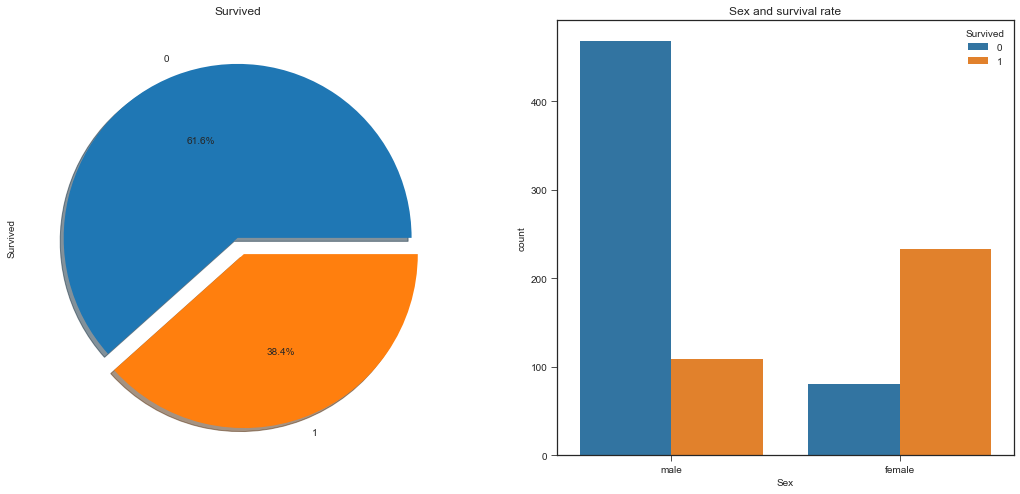

In [138]:
f, ax = plt.subplots(1,2,figsize=(18,8))

df['Survived'].value_counts().plot.pie(explode=[0,0.1], autopct='%1.1f%%',ax=ax[0], shadow=True)
ax[0].set_title('Survived')

sns.countplot(x='Sex', hue='Survived', data=df, ax=ax[1])
ax[1].set_title('Sex and survival rate')

plt.show()

Average age on board: : 30.0


Text(0.5, 0, 'Age')

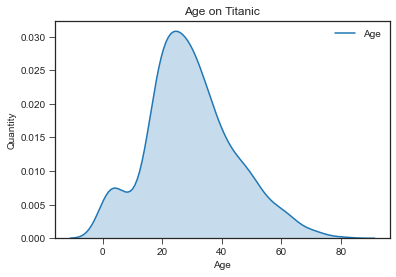

In [139]:
print("Average age on board: :", np.round(df['Age'].mean(),0))
sns.kdeplot(data=df['Age'], shade=True)
plt.title("Age on Titanic")
plt.ylabel('Quantity')
plt.xlabel('Age')

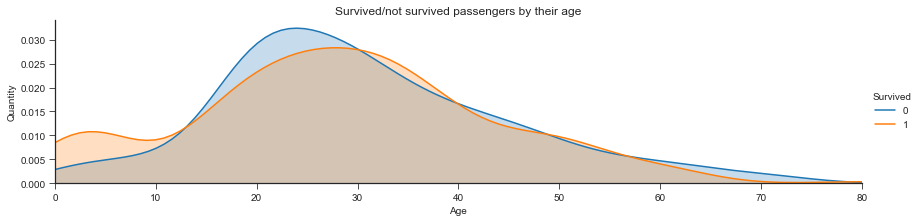

In [140]:
w = sns.FacetGrid(df, hue="Survived",aspect=4)
w.map(sns.kdeplot,'Age',shade= True)
w.set(xlim=(0, df['Age'].max()))
plt.title("Survived/not survived passengers by their age")
plt.ylabel('Quantity')
w.add_legend()

Text(0.5, 1.0, 'Age and survived')

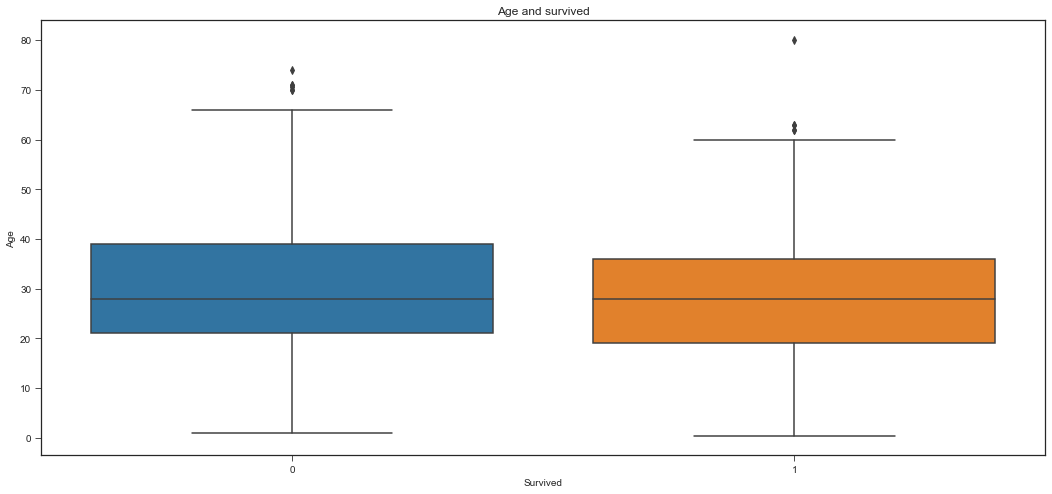

In [141]:
fig, axs = plt.subplots(figsize=(18,8))
sns.boxplot(x='Survived', y='Age', data=df)
plt.title("Age and survived")

The average age of the survivors and non-survivors is comparable.

In [142]:
df.groupby(['Survived'])['Age'].mean()

Survived
0    30.626179
1    28.343690
Name: Age, dtype: float64

The median for survival is lower than for the dead. More elderly people were in the group of the deceased. On the other hand, youth and being a young child did not guarantee survival.

Text(0.5, 1.0, 'Fare and survived')

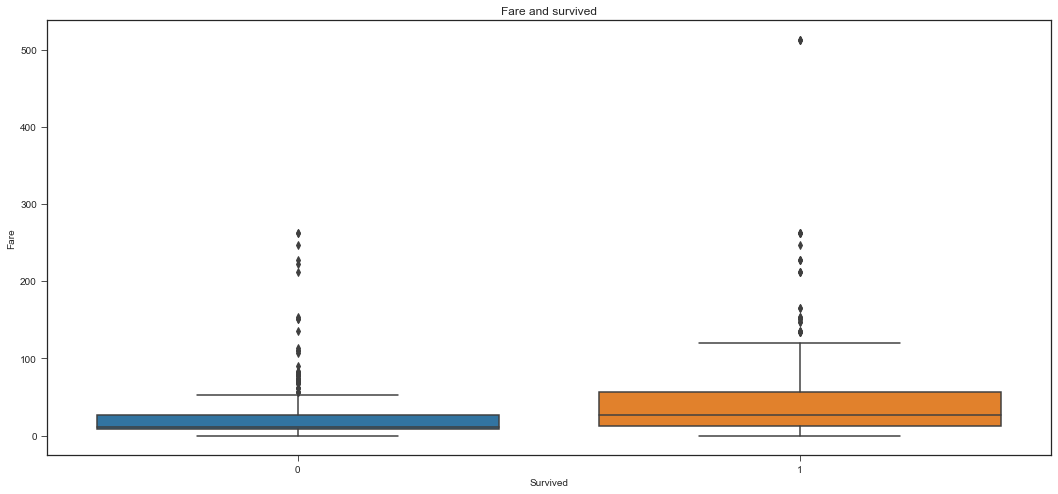

In [143]:
fig, axs = plt.subplots(figsize=(18,8))
sns.boxplot(x='Survived', y='Fare', data=df)

plt.title("Fare and survived")

Remove outlier from df['Fare']

In [144]:
print("Counting of unique values in df.Embarked")
df.Embarked.value_counts()

Counting of unique values in df.Embarked


S    644
C    168
Q     77
Name: Embarked, dtype: int64

Text(0.5, 1.0, 'Fare and survived')

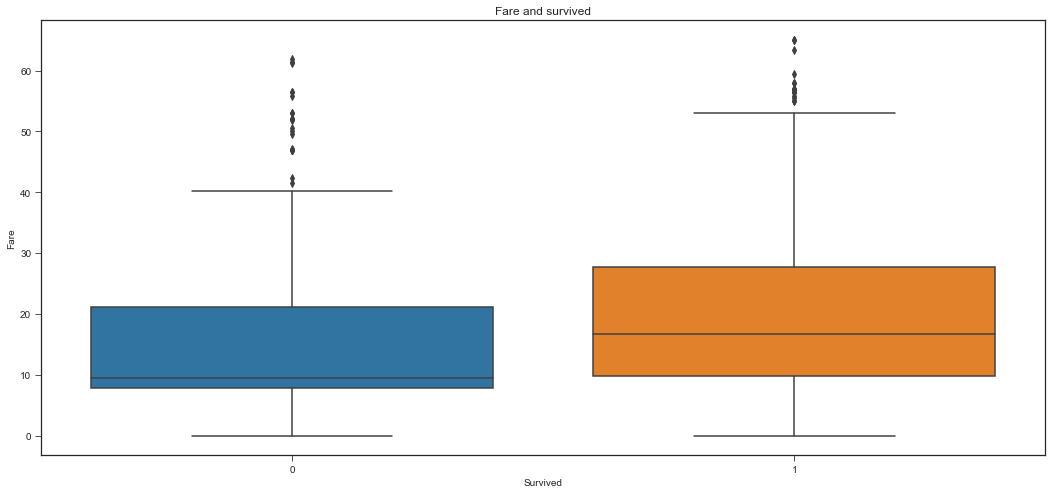

In [145]:
df3 = pd.read_csv("train.csv")

Q1 = df3['Fare'].quantile(0.25)
Q3 = df3['Fare'].quantile(0.75)
IQR = Q3-Q1 
fence_low  = Q1-1.5*IQR
fence_high = Q3+1.5*IQR
mask = (df3['Fare'] > fence_high) | (df3['Fare'] < fence_low)
df3.loc[mask, 'Fare'] = np.nan
    
fig, axs = plt.subplots(figsize=(18,8))
sns.boxplot(x='Survived', y='Fare', data=df3)
plt.title("Fare and survived")

/Users/ola/opt/anaconda3/lib/python3.8/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


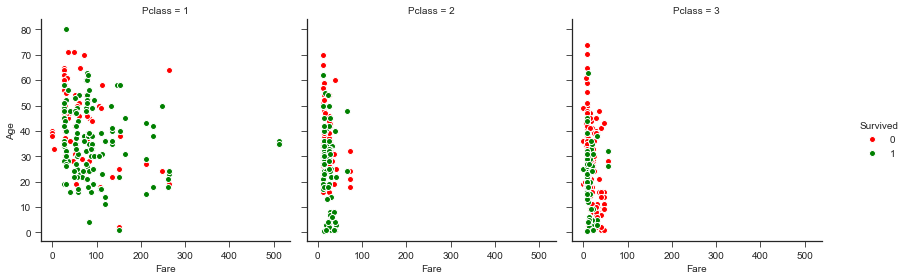

In [146]:
g = sns.FacetGrid(df, hue="Survived", col="Pclass", margin_titles=True,palette={1:"green", 0:"red"}, size=4, aspect=1)
g=g.map(plt.scatter, "Fare", "Age",edgecolor="w").add_legend();

Text(0.5, 0.98, 'Survival by Gender , Age and Fare')

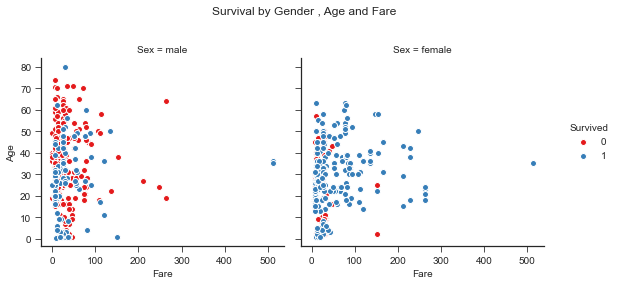

In [147]:
g = sns.FacetGrid(df, hue="Survived", col="Sex", margin_titles=True, palette="Set1", size=4, aspect=1)

g.map(plt.scatter, "Fare", "Age",edgecolor="w").add_legend()
plt.subplots_adjust(top=0.8)

g.fig.suptitle('Survival by Gender , Age and Fare')

## TEST SET

In [148]:
df_test = pd.read_csv("test.csv")
print(df_test.shape)
df_test.head()

(418, 11)


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## CLEANING

In [149]:
# get the number of missing data points per column
missing_values_count = df.isnull().sum()
print(missing_values_count)

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [150]:
# get the number of missing data points per column
missing_values_count_test = df_test.isnull().sum()
print(missing_values_count_test)

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


In [151]:
def cleaning(df, imputer, numFeatures):
    
    #clean numeric data 
    #filll by mean
    df[numFeatures] = imputer.transform(df[numFeatures])

    #Cabin
    df['Cabin'] = [x[0] if isinstance(x, str) else np.nan for x in df['Cabin']]
    df['Cabin'] = df['Cabin'].fillna('no_data')
         
    #Embarked 
    #filling the most common value
    df['Embarked'] = df['Embarked'].fillna('S')
    

In [152]:
target = 'Survived'
numFeatures = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
catFeatures = ['Sex', 'Cabin', 'Embarked']

In [153]:
imputer = SimpleImputer(strategy='mean')
imputer.fit(df[numFeatures])

cleaning(df, imputer, numFeatures)
cleaning(df_test, imputer, numFeatures)

In [154]:
missing_values_count = df.isnull().sum()
print(missing_values_count)

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


In [155]:
missing_values_count_test = df_test.isnull().sum()
print(missing_values_count_test)

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64


## ONE HOT ENCODING

In [156]:
class OneHotEncoder(SklearnOneHotEncoder):
    def __init__(self, **kwargs):
        super(OneHotEncoder, self).__init__(**kwargs)
        self.fit_flag = False

    def fit(self, X, **kwargs):
        out = super().fit(X)
        self.fit_flag = True
        return out

    def transform(self, X, **kwargs):
        sparse_matrix = super(OneHotEncoder, self).transform(X)
        new_columns = self.get_new_columns(X=X)
        d_out = pd.DataFrame(sparse_matrix.toarray(), columns=new_columns, index=X.index)
        return d_out

    def fit_transform(self, X, **kwargs):
        self.fit(X)
        return self.transform(X)

    def get_new_columns(self, X):
        new_columns = []
        for i, column in enumerate(X.columns):
            j = 0
            while j < len(self.categories_[i]):
                new_columns.append(f'{column}_{self.categories_[i][j]}')
                j += 1
        return new_columns


In [157]:
encoder = OneHotEncoder()
encoder_cols_train = encoder.fit_transform(df[catFeatures])
encoder_cols_test = encoder.transform(df_test[catFeatures])

In [158]:
num_df_train = df[numFeatures]
num_df_test = df_test[numFeatures]

target_df_train = df[target]

temp = pd.concat([num_df_train, encoder_cols_train], axis=1)

# Add one-hot encoded columns to numerical features
df = pd.concat([temp, target_df_train], axis=1)
df_test = pd.concat([num_df_test, encoder_cols_test], axis=1)

In [159]:
df.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_no_data,Embarked_C,Embarked_Q,Embarked_S,Survived
0,3.0,22.0,1.0,0.0,7.2500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
1,1.0,38.0,1.0,0.0,71.2833,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2,3.0,26.0,0.0,0.0,7.9250,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
3,1.0,35.0,1.0,0.0,53.1000,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,3.0,35.0,0.0,0.0,8.0500,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0


In [160]:
df_test.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_no_data,Embarked_C,Embarked_Q,Embarked_S
0,3.0,34.5,0.0,0.0,7.8292,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,3.0,47.0,1.0,0.0,7.0000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2,2.0,62.0,0.0,0.0,9.6875,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,3.0,27.0,0.0,0.0,8.6625,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,3.0,22.0,1.0,1.0,12.2875,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [161]:
features = df.columns.tolist()
features.remove(target)

y_train = df[target]
X_train = df[features]
X_test = df_test

## ROC CURVE

In [162]:
def plotROCs(results):
    ''' Function for drawing a series of ROC curve results for 
    individual experiments
     results - results list as 3 element tuples 
     (true, pred, label)
    '''
    
    # Determining the size of the drawing
    fig, ax = plt.subplots(figsize=(10,9))
        
    for true, pred, label in results:
        
        # Calculation of the points needed to draw the ROC curve
        # the roc_curve function concludes three data series, fpr, 
        #tpr, and cutoff levels
        fpr, tpr, thresholds = roc_curve(true, pred)
        
        # We calculate the area under the curve
        rocScore = roc_auc_score(true, pred)
        rocScore = round(rocScore, 3)
        

        # curve thickness
        lw = 2

        # We draw the ROC curve
        ax.plot(fpr, tpr, lw=lw, label=f'{label}: {rocScore}')
        
    # We draw a 45 degree curve as a reference point
    ax.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    
    # We add light margins to the range so that the curve 
    #does not coincide with the axes
    ax.set_xlim([-0.01, 1.0])
    ax.set_ylim([0.0, 1.01])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(f'Receiver operating characteristic - {rocScore}')
    ax.legend(loc="lower right")
    #plt.savefig('ROC.png')
    plt.show()

##### wrapper for cross validation

In [163]:
def CVmodel(nFolds = 5, randomState=2020, debug=False, features=features, 
            model = SVC(), df = df):
    
    kf = KFold(n_splits=nFolds, shuffle=True, random_state=randomState)

    # To save memory, the folder information is only line numbers
    testResults = []
    
    # the results on the training set
    trainResults = []
    
    # predictions for individual folds
    predictions = []
    
    # the index in the original file
    indices = []
    
    for train, test in kf.split(df.index.values):
        
        if debug:
            print(model)
       
        model.fit(df.iloc[train][features], df.iloc[train][target])
        
        predsTrain = model.predict_proba(df.iloc[train][features])[:,1]
        preds = model.predict_proba(df.iloc[test][features])[:,1]
        
        # information about predictions for this fold
        predictions.append(preds.tolist().copy())
        
        # indexed in the original data frame
        indices.append(df.iloc[test].index.tolist().copy())
        
        # The fit is counted using the ROC-AUC metric
        trainScore = roc_auc_score(df[target].iloc[train], predsTrain)
        testScore = roc_auc_score(df[target].iloc[test], preds)
        
        # Saving the results to the list 
        trainResults.append(trainScore)
        testResults.append(testScore)

        
        # Information about each folder together with training results
        #can be optionally displayed in the process
        if debug:
            print("Train AUC:", trainScore,
                  "Valid AUC:", testScore)
    
        
    return trainResults, testResults, predictions, indices

In [164]:
def draw(k, k_name, trainResults, testResults):
    fig, axs = plt.subplots(2)
    axs[0].plot(k,trainResults, 'go-')
    axs[0].set_xlabel(k_name)
    axs[0].set_ylabel("trainResults")
    for x, y in zip(k,trainResults):
        label = "{:.2f}".format(y)
        axs[0].annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center') 
    
    axs[1].plot(k,testResults, 'go-')
    axs[1].set_xlabel(k_name)
    axs[1].set_ylabel("testResults")
    for x, y in zip(k,testResults):
        label = "{:.2f}".format(y)
        axs[1].annotate(label, (x,y), textcoords="offset points", xytext=(0,10), ha='center') 
        
    fig.tight_layout()
    

## RANDOM FOREST ALGORITHM

In [165]:
rfc = RandomForestClassifier(random_state=2020, n_jobs=-1)
trainResults, testResults, predictions, indices = CVmodel(debug=True, model=rfc)
print(np.mean(testResults))
print(testResults)

RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 0.9985293128949846 Valid AUC: 0.845945945945946
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 0.9980559614383366 Valid AUC: 0.906925566343042
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 0.9982087029995775 Valid AUC: 0.8433704129906662
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 0.9974023022096667 Valid AUC: 0.8737980769230769
RandomForestClassifier(n_jobs=-1, random_state=2020)
Train AUC: 0.9981262229297251 Valid AUC: 0.8461174242424243
0.863231485289031
[0.845945945945946, 0.906925566343042, 0.8433704129906662, 0.8737980769230769, 0.8461174242424243]


You can see that the trees in the Random Forest were overfitted.

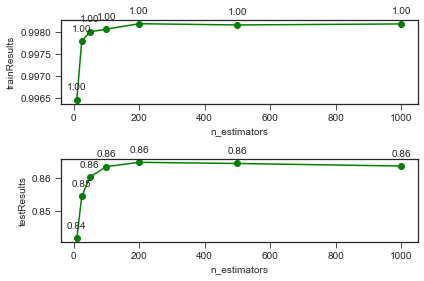

In [166]:
trainResultsArr =[]
kArr =[]
testResultsArr=[]
k_name='n_estimators'

for k in [10, 25, 50, 100, 200, 500, 1000]: 
    rfc = RandomForestClassifier(random_state=2020, n_jobs=-1, n_estimators=k)
    trainResults, testResults, predictions, indices = CVmodel(model=rfc)
    trainResultsArr.append(np.mean(trainResults))
    kArr.append(k)
    testResultsArr.append(np.mean(testResults))
    
draw(kArr, k_name, trainResultsArr, testResultsArr)


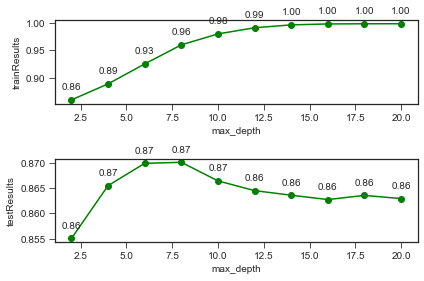

In [167]:
trainResultsArr =[]
kArr =[]
testResultsArr=[]
k_name='max_depth'

for k in range(2,22,2):
    rfc = RandomForestClassifier(random_state=2020, n_jobs=-1, n_estimators=200, 
                                 max_depth=k)
    trainResults, testResults, predictions, indices =  CVmodel(model=rfc)
    trainResultsArr.append(np.mean(trainResults))
    kArr.append(k)
    testResultsArr.append(np.mean(testResults))
    
draw(kArr, k_name, trainResultsArr, testResultsArr)

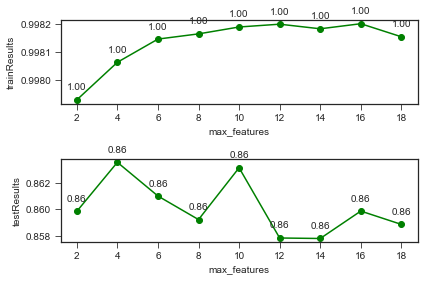

In [168]:
trainResultsArr =[]
kArr =[]
testResultsArr=[]
k_name='max_features'

for k in range(2, len(features) + 1,2):
    rfc = RandomForestClassifier(random_state=2020, n_jobs=-1, n_estimators=200, 
                                 max_depth=18, max_features=k)
    trainResults, testResults, predictions, indices = CVmodel(model=rfc)
    trainResultsArr.append(np.mean(trainResults))
    kArr.append(k)
    testResultsArr.append(np.mean(testResults))
    
draw(kArr, k_name, trainResultsArr, testResultsArr)

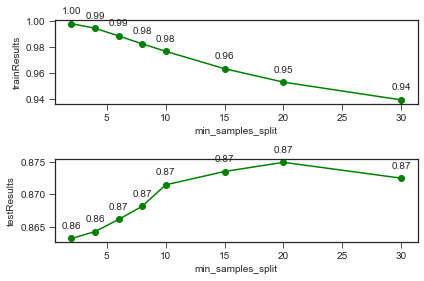

In [169]:
trainResultsArr =[]
kArr =[]
testResultsArr=[]
k_name='min_samples_split'

for k in [2, 4, 6, 8, 10, 15, 20, 30]:
    rfc = RandomForestClassifier(random_state=2020, n_jobs=-1, n_estimators=200, 
                                 max_depth=18, max_features=10, min_samples_split=k)
    trainResults, testResults, predictions, indices = CVmodel(model=rfc)
    trainResultsArr.append(np.mean(trainResults))
    kArr.append(k)
    testResultsArr.append(np.mean(testResults))
    
draw(kArr, k_name, trainResultsArr, testResultsArr)

In [170]:
rfc = RandomForestClassifier(random_state=2020, n_jobs=-1, n_estimators=200, 
                                 max_depth=18, max_features=10, min_samples_split=15)


trainResults, testResults, predictions, indices = CVmodel(model=rfc)
print(np.mean(testResults))

modelRF = {
    "name":"model_rf",
    "description":"Model RF",
    "specification":'n_estimators=100, max_depth=20, max_features=10, min_samples_split=10',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.8735231595130359


In [171]:
# open the file for binary writing using "with"
with open("model_RF.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelRF, fp)

##### Cross Validation

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split( 
                        X_train, y_train, test_size=0.5, random_state=0) 

### Apply GridSearchCV to Random Forest

In [176]:
param = { 'max_depth': [2, 10, 20],
         'n_estimators': [50, 100, 500],
         'max_features': [2, 10 , 20],
         'min_samples_split': [2, 10, 20]}

grid_rf = GridSearchCV(RandomForestClassifier(), param, 
                       refit = True, verbose = 3,n_jobs=-1) 
  
# fitting the model for grid search 
grid_rf.fit(Xtrain, ytrain) 

# print best parameter after tuning 
print(grid_rf.best_params_) 
grid_rf_predictions = grid_rf.predict(Xtest) 
  
# print classification report 
print(classification_report(ytest, grid_rf_predictions)) 



Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  1.1min finished


{'max_depth': 10, 'max_features': 10, 'min_samples_split': 20, 'n_estimators': 500}
              precision    recall  f1-score   support

           0       0.84      0.87      0.86       283
           1       0.76      0.72      0.74       163

    accuracy                           0.82       446
   macro avg       0.80      0.80      0.80       446
weighted avg       0.81      0.82      0.81       446



best result: {'max_depth': 10, 'max_features': 10, 'min_samples_split': 20, 'n_estimators': 500}

In [179]:
param = { 'max_depth': [5, 10, 15],
         'n_estimators': [250, 500, 750],
         'max_features': [5,10,15],
         'min_samples_split': [15, 20, 25]}

grid_rf = GridSearchCV(RandomForestClassifier(), param, 
                       refit = True, verbose = 3,n_jobs=-1) 
  
# fitting the model for grid search 
grid_rf.fit(Xtrain, ytrain) 

# print best parameter after tuning 
print(grid_rf.best_params_) 
grid_rf_predictions = grid_rf.predict(Xtest) 
  
# print classification report 
print(classification_report(ytest, grid_rf_predictions)) 

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   52.3s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed:  3.0min finished


{'max_depth': 5, 'max_features': 10, 'min_samples_split': 20, 'n_estimators': 500}
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       283
           1       0.76      0.72      0.74       163

    accuracy                           0.82       446
   macro avg       0.80      0.80      0.80       446
weighted avg       0.81      0.82      0.82       446



In [180]:
rfc_gscv = RandomForestClassifier(random_state=2020, n_jobs=-1, n_estimators=500, 
                                 max_depth=5, max_features=10, min_samples_split=20)


trainResults, testResults, predictions, indices = CVmodel(model=rfc_gscv)
print(np.mean(testResults))

modelRF_GSCV = {
    "name":"model_RF_GSCV",
    "description":"Model RF with GridSearchCV",
    "specification":'n_estimators=500, max_depth=6, max_features=8, min_samples_split=4',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}


0.8655021112264876


In [181]:
# open the file for binary writing using "with"
with open("model_RF_GSCV.p", "wb") as fp:
    pickle.dump(modelRF_GSCV, fp)

## NORMALIZATION

In [182]:
#Select numerical columns which needs to be normalized
train_norm = df[numFeatures]
test_norm = df[numFeatures]
 
std_scale = preprocessing.StandardScaler().fit(train_norm)

# Normalize TRANING Data
x_train_norm = std_scale.transform(train_norm)
#Converting numpy array to dataframe
training_norm_col = pd.DataFrame(x_train_norm, index=train_norm.index, 
                                 columns=train_norm.columns) 
#Update
df[numFeatures]=training_norm_col


# Normalize TESTING Data by using mean and SD of training set
x_test_norm = std_scale.transform(test_norm)
#Converting numpy array to dataframe
testing_norm_col = pd.DataFrame(x_test_norm, index=test_norm.index, 
                                columns=test_norm.columns) 
#Update
df[numFeatures] = testing_norm_col
df.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_no_data,Embarked_C,Embarked_Q,Embarked_S,Survived
0,0.827377,-0.592481,0.432793,-0.473674,-0.502445,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0
1,-1.566107,0.638789,0.432793,-0.473674,0.786845,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1
2,0.827377,-0.284663,-0.474545,-0.473674,-0.488854,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
3,-1.566107,0.407926,0.432793,-0.473674,0.420730,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,0.827377,0.407926,-0.474545,-0.473674,-0.486337,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0


## K-NEAREST NEIGHBORS ALGORITHM

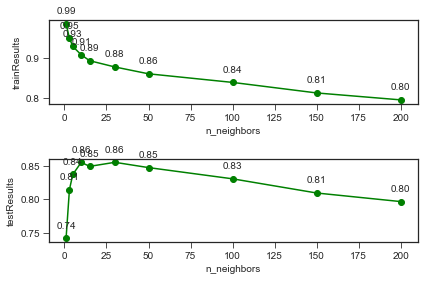

In [183]:
trainResultsArr =[]
kArr =[]
testResultsArr=[]
k_name='n_neighbors'

for k in [1, 3, 5, 10, 15, 30, 50, 100, 150, 200]:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k, n_jobs=-1, p=2)
    trainResults, testResults, predictions, indices = CVmodel(model=knn)
    trainResultsArr.append(np.mean(trainResults))
    kArr.append(k)
    testResultsArr.append(np.mean(testResults))
    
draw(kArr, k_name, trainResultsArr, testResultsArr)

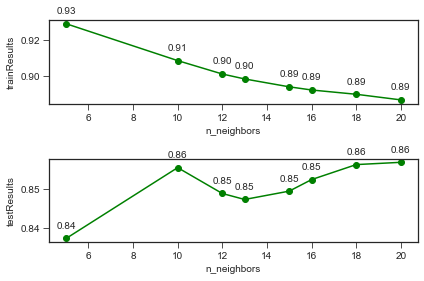

In [215]:
trainResultsArr =[]
kArr =[]
testResultsArr=[]
k_name='n_neighbors'

for k in [5, 10, 12, 13, 15, 16, 18, 20]:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k, n_jobs=-1, p=2)
    trainResults, testResults, predictions, indices = CVmodel(model=knn)
    trainResultsArr.append(np.mean(trainResults))
    kArr.append(k)
    testResultsArr.append(np.mean(testResults))
    
draw(kArr, k_name, trainResultsArr, testResultsArr)

In the next step, it is worth checking whether the Manhattan measure will give better results.

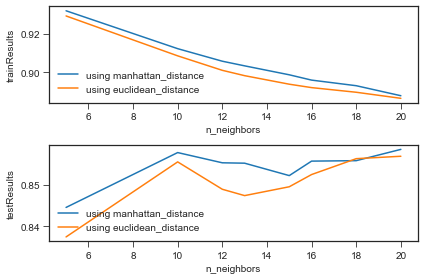

In [216]:
trainResultsArr2 =[]
kArr2 =[]
testResultsArr2 =[]

for k in [5, 10, 12, 13, 15, 16, 18, 20]:
    knn = neighbors.KNeighborsClassifier(n_neighbors=k, n_jobs=-1, p=1)
    trainResults, testResults, predictions, indices = CVmodel(model=knn)
    trainResultsArr2.append(np.mean(trainResults))
    testResultsArr2.append(np.mean(testResults))
    
fig, (ax1, ax2) = plt.subplots(2)

ax1.plot(kArr,trainResultsArr2)
ax1.plot(kArr,trainResultsArr)
ax1.set_xlabel(k_name)
ax1.set_ylabel("trainResults")
ax1.legend(['using manhattan_distance', 'using euclidean_distance'], loc='lower left')
    
ax2.plot(kArr, testResultsArr2)
ax2.plot(kArr, testResultsArr)
ax2.set_xlabel(k_name)
ax2.set_ylabel("testResults")
ax2.legend(['using manhattan_distance', 'using euclidean_distance'], loc='lower left')

fig.tight_layout()

('Sex_female', 0.766904223550039)
('Sex_male', 0.766904223550039)
('Fare', 0.7105463868062951)
('Pclass', 0.6662174914977852)
('Cabin_no_data', 0.6354133097000861)
('Embarked_S', 0.568158707912364)
('Parch', 0.5551129399232816)
('Embarked_C', 0.5488585974945199)
('Cabin_B', 0.5399250045027973)
('Age', 0.5317386714158252)
('Cabin_C', 0.5300533548861557)
('Cabin_D', 0.529120174918565)
('Cabin_E', 0.5282167900427395)
('SibSp', 0.5064623098759757)
('Cabin_F', 0.5017370677095083)
('Cabin_T', 0.5)
('Cabin_G', 0.4999920132610006)
('Embarked_Q', 0.49895842429638665)
('Cabin_A', 0.49830618249064845)


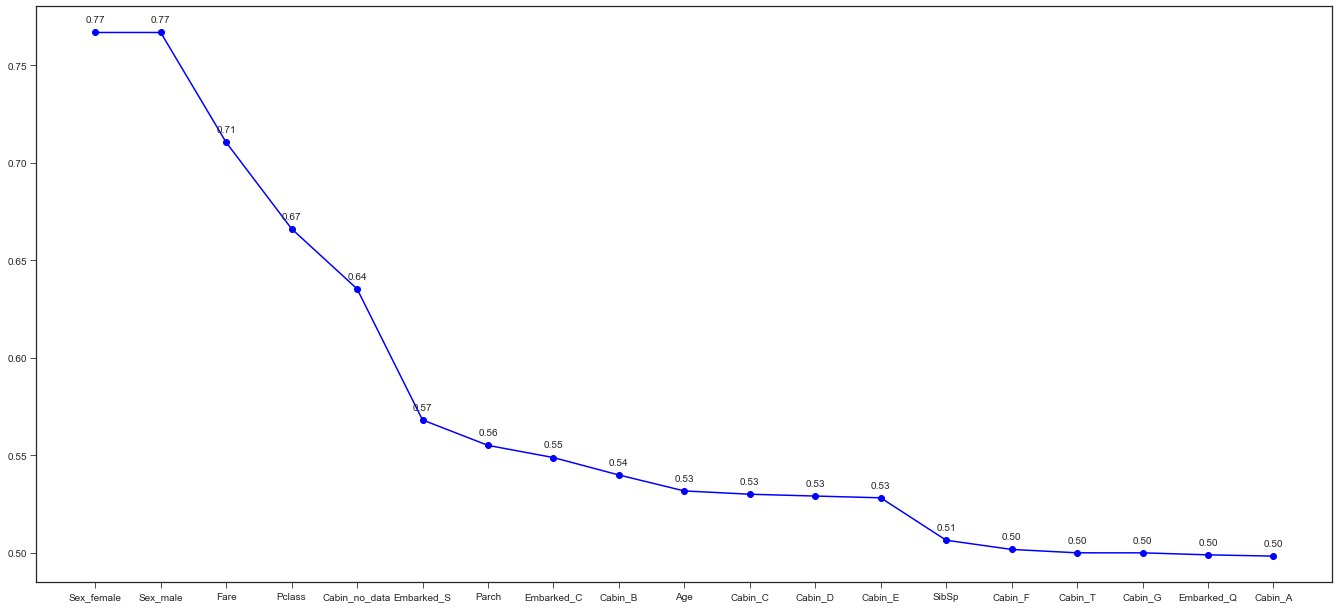

In [217]:
selectedFeatures = []
results = []
knn = neighbors.KNeighborsClassifier(n_neighbors=10, n_jobs=-1, p=1)

for feature in features:
    featuresCandidates = selectedFeatures.copy()
    featuresCandidates.append(feature)
    trainResults, testResults, predictions, indices = CVmodel(model=knn, 
                                                              features=featuresCandidates)
    results.append((feature, np.mean(testResults)))
    
results = sorted(results, key=lambda x: x[1], reverse=True)

results2 = [(elem1, (elem2)) for elem1, elem2 in results]
for result in results2:
    print(result)
fig = plt.figure()
ax = fig.add_axes([0,0,3,2])
ax.plot(*zip(*results2), 'bo-')
for x, y in results2:
    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center
plt.show()

In [218]:
featuresSet_testResluts_score = []

In [219]:
trainResults, testResults, predictions, indices = CVmodel(model=knn,
                                                          features=features)
featuresSet_testResluts_score.append(('all', np.mean(testResults)))
print(np.mean(testResults))

0.8576920894899726


all features for which the obtained result was above 0.5

In [220]:
featuresSet2 = [x for x,y in results if y > 0.5]
print(featuresSet2)
trainResults, testResults, predictions, indices = CVmodel(model=knn,
                                                          features=featuresSet2)
featuresSet_testResluts_score.append(('Above-0.5', np.mean(testResults)))
print(np.mean(testResults))

['Sex_female', 'Sex_male', 'Fare', 'Pclass', 'Cabin_no_data', 'Embarked_S', 'Parch', 'Embarked_C', 'Cabin_B', 'Age', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'SibSp', 'Cabin_F']
0.8597080567096084


all features for which the obtained result was above 0.6

In [221]:
featuresSet3 = [x for x,y in results if y > 0.6]
print(featuresSet3)

trainResults, testResults, predictions, indices = CVmodel(model=knn,
                                                          features=featuresSet3)
featuresSet_testResluts_score.append(('Above-0.6', np.mean(testResults)))
print(np.mean(testResults))

['Sex_female', 'Sex_male', 'Fare', 'Pclass', 'Cabin_no_data']
0.8346612627729133


all features for which the obtained result was above 0.7

In [222]:
featuresSet4 = [x for x,y in results if y > 0.7]
print(featuresSet4)
trainResults, testResults, predictions, indices = CVmodel(model=knn,
                                                          features=featuresSet4)
featuresSet_testResluts_score.append(('Above-0.7', np.mean(testResults)))
print(np.mean(testResults))

['Sex_female', 'Sex_male', 'Fare']
0.8303367577427426


all features for which the obtained result was above 0.55

In [223]:
featuresSet5 = [x for x,y in results if y > 0.55]
print(featuresSet5)
trainResults, testResults, predictions, indices = CVmodel(model=knn,
                                                          features=featuresSet5)
featuresSet_testResluts_score.append(('Above-0.55', np.mean(testResults)))
print(np.mean(testResults))

['Sex_female', 'Sex_male', 'Fare', 'Pclass', 'Cabin_no_data', 'Embarked_S', 'Parch']
0.8375663588488186


all features for which the obtained result was above 0.53

In [224]:
featuresSet6 = [x for x,y in results if y > 0.53]
print(featuresSet6)
trainResults, testResults, predictions, indices = CVmodel(model=knn,
                                                          features=featuresSet6)
featuresSet_testResluts_score.append(('Above-0.53', np.mean(testResults)))
print(np.mean(testResults))

['Sex_female', 'Sex_male', 'Fare', 'Pclass', 'Cabin_no_data', 'Embarked_S', 'Parch', 'Embarked_C', 'Cabin_B', 'Age', 'Cabin_C']
0.8507125191614409


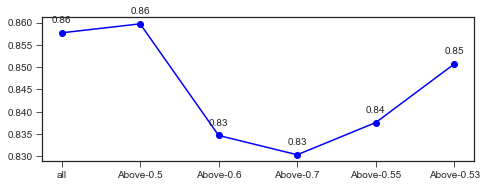

In [225]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,0.5])
ax.plot(*zip(*featuresSet_testResluts_score), 'bo-')
for x, y in featuresSet_testResluts_score:
    label = "{:.2f}".format(y)

    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10),
                 ha='center') 
plt.show()

We'll get little improvment by choosing features above 0.5

In [196]:
dfCopy = df.copy()

In [226]:
selectedFeatures = []
results = []
knn = neighbors.KNeighborsClassifier(n_neighbors=10, n_jobs=-1, p=1)

for feature in featuresSet2:
    featuresCandidates = selectedFeatures.copy()
    featuresCandidates.append(feature)
    trainResults, testResults, predictions, indices = CVmodel(model=knn, 
                                                              features=featuresCandidates)
    results.append((feature, np.mean(testResults)))
    
results = sorted(results, key=lambda x: x[1], reverse=True)


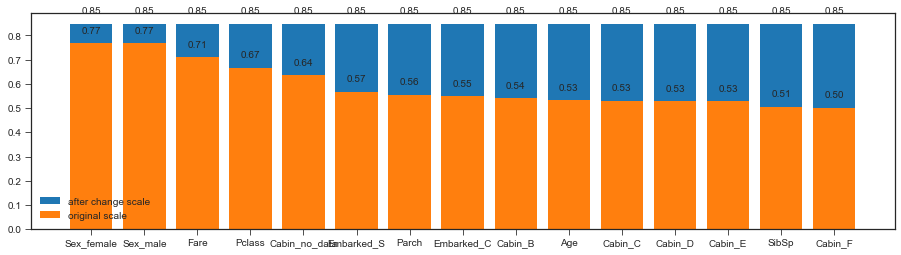

In [264]:
# Then we will add each variable as a candidate.
results2 = []
for feature in featuresSet2:
    df = dfCopy.copy()
    # We double the variable
    df[feature]=df[feature]*2
#    validation
    trainResults, testResults, predictions, indices = CVmodel(model=knn,
                                                          features=featuresSet2)
    results2.append((feature, np.mean(testResults)))

# Sorting the results
results2 = sorted(results2, key=lambda x: x[1], reverse=True)
    
fig = plt.figure()
ax = fig.add_axes([0,0,2,0.75])
ax.bar(*zip(*results2))

for x, y in results2:
    label = "{:.2f}".format(y)

    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10),
                 ha='center') 
ax.bar(*zip(*results))
for x, y in results:
    label = "{:.2f}".format(y)

    plt.annotate(label, (x,y), textcoords="offset points", xytext=(0,10),
                 ha='center')
ax.legend(['after change scale', 'original scale'], loc='lower left')
plt.show()


We can check how the algorithm will behave if we change the scale for individual features. For each of the features, we will successively double their scale relative to the other features.

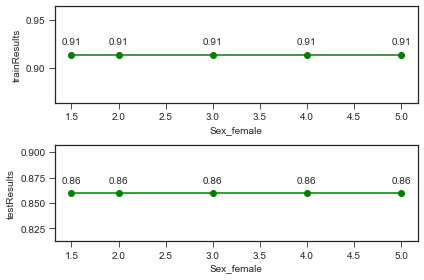

In [228]:
knn = neighbors.KNeighborsClassifier(n_neighbors=10, n_jobs=-1, p=1)
trainResultsArr =[]
kArr =[]
testResultsArr=[]
k_name='Sex_female'

for k in [1.5, 2, 3, 4, 5]:
    df = dfCopy.copy()
    # we increment the feature k times
    df["Sex_female"]=df["Sex_female"]*k
    trainResults, testResults, predictions, indices = CVmodel(model=knn,
                                                          features=featuresSet2)
    trainResultsArr.append(np.mean(trainResults))
    kArr.append(k)
    testResultsArr.append(np.mean(testResults))
    
draw(kArr, k_name, trainResultsArr, testResultsArr)

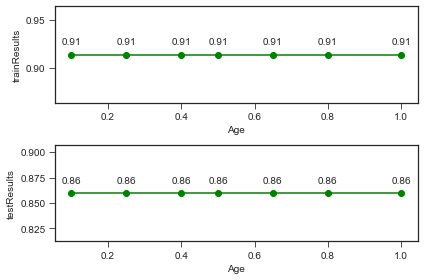

In [229]:
trainResultsArr =[]
kArr =[]
testResultsArr=[]
k_name='Age'


for k in [0.1, 0.25, 0.4, 0.5, 0.65,  0.8, 1]:
    df = dfCopy.copy()
    
    # For the best value of k for duration so far, 
    #we set the multiplier and look for the next variable
    df["Sex_female"]=df["Sex_female"]*1
    
    # we increment the variable k times
    df['Age']=df['Age']*k
    trainResults, testResults, predictions, indices = CVmodel(model=knn,
                                                          features=featuresSet2)
    trainResultsArr.append(np.mean(trainResults))
    kArr.append(k)
    testResultsArr.append(np.mean(testResults))
    
draw(kArr, k_name, trainResultsArr, testResultsArr)

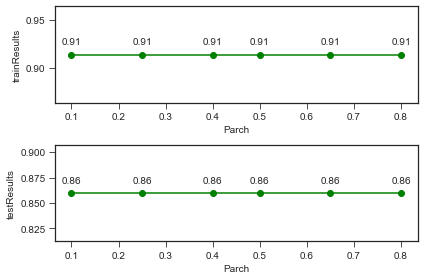

In [230]:
trainResultsArr =[]
kArr =[]
testResultsArr=[]
k_name='Parch'



for k in [0.1, 0.25, 0.4, 0.5, 0.65,  0.8]:
    df = dfCopy.copy()
    
    df["Age"]=df["Age"]*1
    
    df['Parch']=df['Parch']*k
    trainResults, testResults, predictions, indices = CVmodel(model=knn,
                                                          features=featuresSet2)
    trainResultsArr.append(np.mean(trainResults))
    kArr.append(k)
    testResultsArr.append(np.mean(testResults))
    
draw(kArr, k_name, trainResultsArr, testResultsArr)

In [231]:
knn = neighbors.KNeighborsClassifier(n_neighbors=10, n_jobs=-1, p=1)

trainResults, testResults, predictions, indices = CVmodel(model=knn, df = df,
                                                          features=featuresSet2)
print(np.mean(testResults))

modelknn = {
    "name":"KNN",
    "description":"First KNN model",
    "specification":'n_neighbors=13, n_jobs=-1, p=1, features=featuresSet2',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.8582917154411408


In [232]:
with open("model_knn.p", "wb") as fp:
    pickle.dump(modelknn, fp)

### Apply GridSearchCV to K Neighbors Classifier

In [213]:
param = {'n_neighbors': [5, 25, 50],
         'weights': ['uniform', 'distance'],
         'p': [1, 2]}

grid_knn = GridSearchCV(neighbors.KNeighborsClassifier(), param, 
                       refit = True, verbose = 3,n_jobs=-1) 
  
# fitting the model for grid search 
grid_knn.fit(Xtrain, ytrain) 

# print best parameter after tuning 
print(grid_knn.best_params_) 
grid_knn_predictions = grid_knn.predict(Xtest) 
  
# print classification report 
print(classification_report(ytest, grid_knn_predictions)) 



Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'n_neighbors': 25, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       283
           1       0.71      0.55      0.62       163

    accuracy                           0.75       446
   macro avg       0.74      0.71      0.72       446
weighted avg       0.75      0.75      0.74       446



[Parallel(n_jobs=-1)]: Done  53 out of  60 | elapsed:    0.6s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.6s finished


best result: {'n_neighbors': 25, 'p': 1, 'weights': 'distance'}

In [233]:
param = {'n_neighbors': [20, 25, 30],
         'weights': ['uniform', 'distance'],
         'p': [1, 2]}

grid_knn = GridSearchCV(neighbors.KNeighborsClassifier(), param, 
                       refit = True, verbose = 3,n_jobs=-1) 
  
# fitting the model for grid search 
grid_knn.fit(Xtrain, ytrain) 

# print best parameter after tuning 
print(grid_knn.best_params_) 
grid_knn_predictions = grid_knn.predict(Xtest) 
  
# print classification report 
print(classification_report(ytest, grid_knn_predictions)) 

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


{'n_neighbors': 25, 'p': 1, 'weights': 'distance'}
              precision    recall  f1-score   support

           0       0.77      0.87      0.82       283
           1       0.71      0.55      0.62       163

    accuracy                           0.75       446
   macro avg       0.74      0.71      0.72       446
weighted avg       0.75      0.75      0.74       446



[Parallel(n_jobs=-1)]: Done  53 out of  60 | elapsed:    0.4s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.4s finished


best result: {'n_neighbors': 25, 'p': 1, 'weights': 'distance'}

In [235]:
knn_gscv = neighbors.KNeighborsClassifier(n_neighbors=25, p=1, weights='distance')

trainResults, testResults, predictions, indices = CVmodel(model=knn_gscv, df = df)
print(np.mean(testResults))

modelkNN_GSCV = {
    "name":"KNN_GridSearchCV",
    "description":"Pierwszy dopracowany model KNN, 13 sąsiadów, i ograniczona liczba zmodyfkowanych zmiennych",
    "specification":'n_neighbors=13, n_jobs=-1, p=1, features=featuresSet2',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.8489991283093008


In [236]:
with open("model_knn_GSCV.p", "wb") as fp:
    pickle.dump(modelkNN_GSCV, fp)

# Support Vector Machine

In [240]:
#random values SVC
svm = SVC(C=1, # penalty value for a classification error
            cache_size=500, 
            kernel='linear', 
            max_iter=-1, 
            probability=True, # should the function return probabilities?
            tol=0.001, 
            verbose=False)

trainResults, testResults, predictions, indices = CVmodel(model = svm)
print(np.mean(testResults))

0.8287511387011047


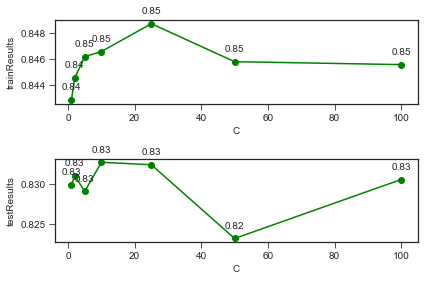

In [245]:
trainResultsArr =[]
kArr =[]
testResultsArr=[]
k_name='C'

for c in [1, 2, 5, 10, 25, 50, 100]:
    svm = SVC(kernel="linear",  C=c, probability=True)
    trainResults, testResults, predictions, indices = CVmodel(model=svm, df=df)
    trainResultsArr.append(np.mean(trainResults))
    kArr.append(c)
    testResultsArr.append(np.mean(testResults))
    
draw(kArr, k_name, trainResultsArr, testResultsArr)

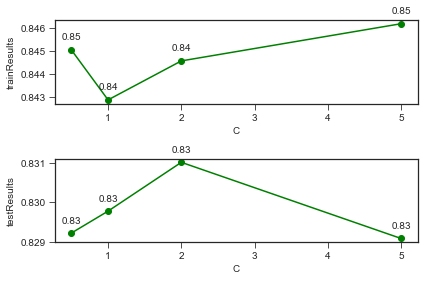

In [247]:
trainResultsArr =[]
kArr =[]
testResultsArr=[]
k_name='C'

for c in [0.5, 1, 2, 5]:
    svm = SVC(kernel="linear",  C=c, probability=True)
    trainResults, testResults, predictions, indices = CVmodel(model=svm, df=df)
    trainResultsArr.append(np.mean(trainResults))
    kArr.append(c)
    testResultsArr.append(np.mean(testResults))
    
draw(kArr, k_name, trainResultsArr, testResultsArr)

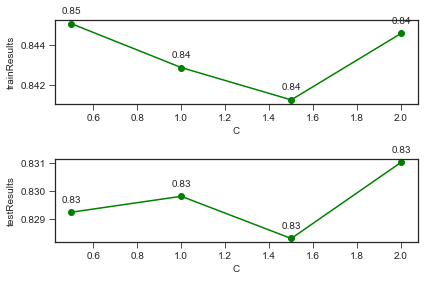

In [248]:
trainResultsArr =[]
kArr =[]
testResultsArr=[]
k_name='C'

for c in [0.5, 1, 1.5, 2]:
    svm = SVC(kernel="linear",  C=c, probability=True)
    trainResults, testResults, predictions, indices = CVmodel(model=svm, df=df)
    trainResultsArr.append(np.mean(trainResults))
    kArr.append(c)
    testResultsArr.append(np.mean(testResults))
    
draw(kArr, k_name, trainResultsArr, testResultsArr)

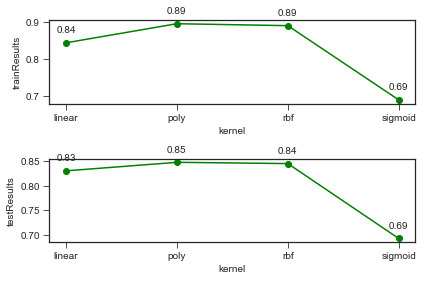

In [260]:
trainResultsArr =[]
kArr =[]
testResultsArr=[]
k_name='kernel'

for ker in ['linear', 'poly', 'rbf', 'sigmoid']:
    svm = SVC(kernel=ker,  C=1, probability=True)
    trainResults, testResults, predictions, indices = CVmodel(model=svm, df=df)
    trainResultsArr.append(np.mean(trainResults))
    kArr.append(ker)
    testResultsArr.append(np.mean(testResults))
    
draw(kArr, k_name, trainResultsArr, testResultsArr)

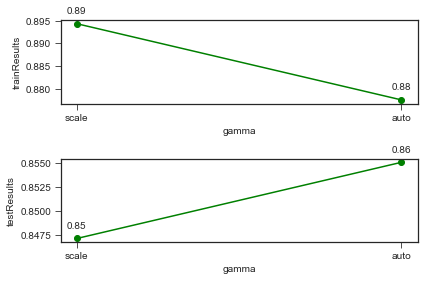

In [258]:
trainResultsArr =[]
kArr =[]
testResultsArr=[]
k_name='gamma'

for g in ['scale', 'auto']:
    svm = SVC(kernel='poly',  C=1, gamma=g, probability=True)
    trainResults, testResults, predictions, indices = CVmodel(model=svm, df=df)
    trainResultsArr.append(np.mean(trainResults))
    kArr.append(g)
    testResultsArr.append(np.mean(testResults))
    
draw(kArr, k_name, trainResultsArr, testResultsArr)

In [255]:
svm = SVC(kernel='poly',  C=1, gamma='auto', probability=True)
trainResults, testResults, predictions, indices = CVmodel(model=svm, df=df)
print(np.mean(testResults))

modelsvm = {
    "name":"SVM",
    "description":"Model SVM  i kernelem RBF",
    "specification":'kernel="rbf" C=c,',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.854941239407305


In [256]:
with open("model_svm.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelsvm, fp)

### Apply GridSearchCV to Support Vector Machine

In [ ]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, y_train, test_size=0.5, random_state=0) 

param = {'C': [1, 5, 10],
         'gamma': ['scale', 'auto'],
         'kernel': ['linear', 'poly', 'rbf']}  
  
grid_svm = GridSearchCV(SVC(probability=True), param, refit = True, verbose = 3, n_jobs=-1) 
  
# fitting the model for grid search 
grid_svm.fit(Xtrain, ytrain) 

# print best parameter after tuning 
print(grid_svm.best_params_) 
grid_svm_predictions = grid_svm.predict(Xtest) 
  
# print classification report 
print(classification_report(ytest, grid_svm_predictions)) 

Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


In [343]:
trainResults, testResults, predictions, indices = CVTestSVM(debug=False, kernel='rbf', 
                                                                C=0.5, gamma=1e-3)
print(np.mean(testResults))

modelsvm_GSCV = {
    "name":"SVM with hyperparameter tuning by GridSearchCV",
    "description":"Model SVM  i kernelem RBF",
    "specification":'kernel="rbf" C=c,',
    "trainResults":trainResults.copy(),
    "testResults":testResults.copy(),
    "predictions":predictions.copy(),
    "indices":indices.copy(),
}

0.8334209431763069


In [344]:
with open("model_svm_GSCV.p", "wb") as fp:
    # Zapisujemy obiekt do wskaźnika pliku
    pickle.dump(modelsvm_GSCV, fp)

# Summary

In [346]:
# Let's also load previously saved models
with open("model_RF.p", "rb") as fp:
    modelRF = pickle.load(fp)
    
with open("model_RF_GSCV.p", "rb") as fp:
    modelRF_GSCV = pickle.load(fp)
    
with open("model_knn.p", "rb") as fp:
    modelknn = pickle.load(fp)
    
with open("model_knn_GSCV.p", "rb") as fp:
    modelknn_GSCV = pickle.load(fp)
    
with open("model_svm.p", "rb") as fp:
    modelsvm = pickle.load(fp)
    
with open("model_svm_GSCV.p", "rb") as fp:
    modelsvm_GSCV = pickle.load(fp)

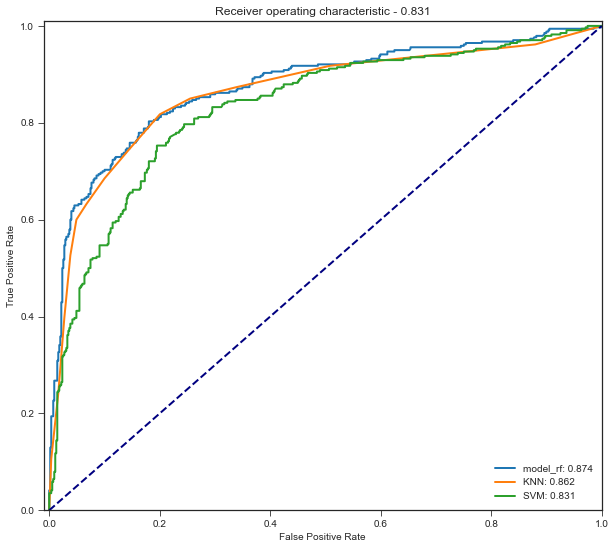

In [347]:
res2plot = []
true = (df[target]==1)
for result in [modelRF, modelknn, modelsvm]:
    # we create a prediction vector creating a pandas series, 
    #and then we sort the index
    pred = pd.Series(sum(result["predictions"], []), 
                     index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# We call the drawing function
plotROCs(res2plot)

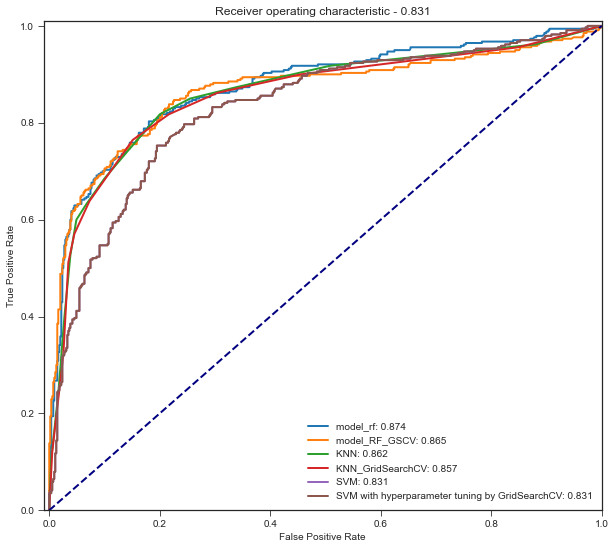

In [354]:
res2plot = []
true = (df[target]==1)
for result in [modelRF,modelRF_GSCV, modelknn,modelknn_GSCV, modelsvm,modelsvm_GSCV]:
    # we create a prediction vector creating a pandas series, 
    #and then we sort the index
    pred = pd.Series(sum(result["predictions"], []), 
                     index=sum(result["indices"], [])).sort_index()
    res2plot.append((true, pred, result["name"]))
    
# We call the drawing function
plotROCs(res2plot)

### Random Forest after hyperparameter tuning gives the best result.

Survival prediction with the model with the best ROC AUC SCORE

In [356]:
model = RandomForestClassifier(n_estimators=500, max_depth=6, max_features=8, 
                               min_samples_split=4)
model.fit(df.loc[:, df.columns != target], df[target])
predictions = model.predict(df_test)
output = pd.DataFrame({'index': df_test.index, 'Survived': predictions})
output.to_csv('survival_on_Titanic_predicton.csv', index=False)
print("END OF THE PROJECT")

END OF THE PROJECT
